<a href="https://colab.research.google.com/github/NishatVasker/CSE488_Big-Data-Analytics-/blob/main/lab_03_E_commerce_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mrjob
import pandas as pd
from itertools import combinations
from mrjob.job import MRJob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 8.1 MB/s eta 0:00:00


# **Step 1: Analyze and Visualize the Dataset**

Analyze and visualize the dataset to identify trends or insights.

Dataset Preview:
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1  536365     71053                  WHITE METAL LANTERN         6   
2  536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3  536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4  536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  Price  Customer ID         Country  
0 2010-12-01 08:26:00   2.55      17850.0  United Kingdom  
1 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
2 2010-12-01 08:26:00   2.75      17850.0  United Kingdom  
3 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  
4 2010-12-01 08:26:00   3.39      17850.0  United Kingdom  

Top 10 Most Frequently Purchased Items:
Description
WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING       

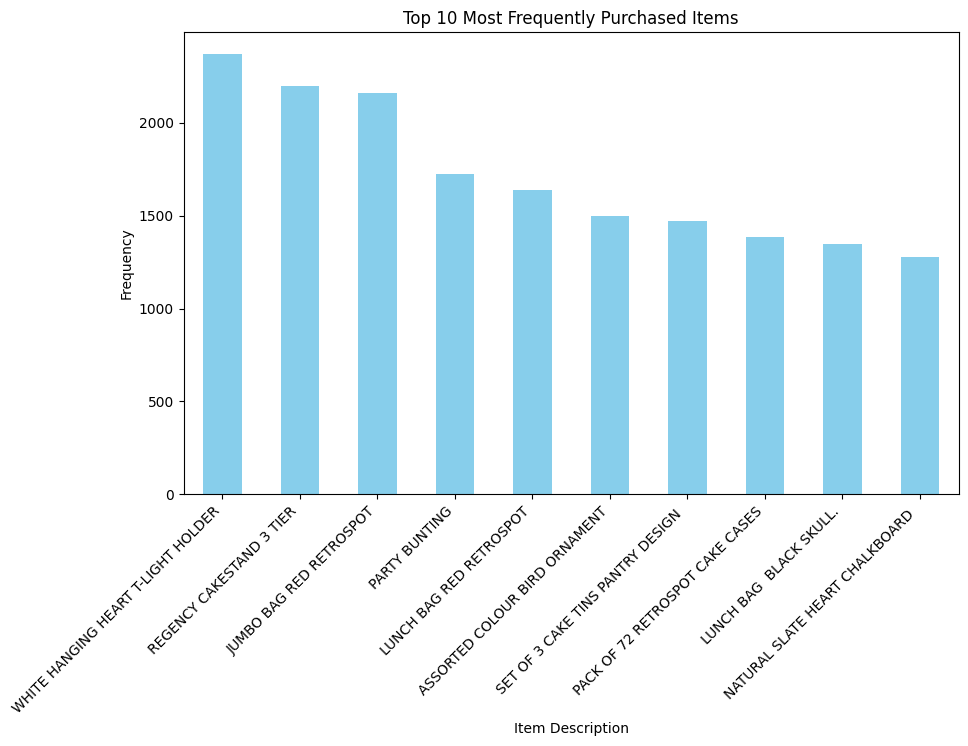

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/retail_data.xlsx'  # Replace with the correct dataset path
data = pd.read_excel(file_path, sheet_name='Year 2010-2011')

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Analyze the dataset: count the most frequently purchased items
print("\nTop 10 Most Frequently Purchased Items:")
top_items = data['Description'].value_counts().head(10)
print(top_items)

# Visualize the top 10 most frequently purchased items
plt.figure(figsize=(10, 6))
top_items.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Frequently Purchased Items')
plt.xlabel('Item Description')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


# **Step 2: Prepare the Dataset for Frequent Itemsets Mining**

Prepare the data to save transactions in the required format for mrjob.

In [ ]:
# Group transactions by Invoice, creating a list of items purchased per transaction
transactions = data.groupby('Invoice')['Description'].apply(list)

# Convert all items in transactions to strings and handle NaN values
transactions = transactions.apply(lambda x: [str(item) for item in x if pd.notna(item)])

# Save transactions to a text file (each line represents one transaction)
with open('transactions.txt', 'w') as f:
    for transaction in transactions:
        f.write(','.join(transaction) + '\n')

print("\nTransactions saved to 'transactions.txt' for frequent itemsets mining.")



Transactions saved to 'transactions.txt' for frequent itemsets mining.


# **Step 3: Define the MapReduce Job for Frequent Itemsets Mining**

Define the mrjob MapReduce script.

In [ ]:
# Save the MRJob script to a Python file
with open('frequent_itemsets_mr.py', 'w') as f:
    f.write("""
from mrjob.job import MRJob
from itertools import combinations

class MRFrequentItemsets(MRJob):
    def configure_args(self):
        super(MRFrequentItemsets, self).configure_args()
        self.add_passthru_arg('--min-support', type=int, default=2, help='Minimum support threshold')

    def mapper(self, _, line):
        items = line.strip().split(',')
        for itemset in combinations(items, 2):  # Generate pairs
            yield itemset, 1

    def combiner(self, itemset, counts):
        yield itemset, sum(counts)

    def reducer(self, itemset, counts):
        total_count = sum(counts)
        if total_count >= self.options.min_support:
            yield itemset, total_count

if __name__ == '__main__':
    MRFrequentItemsets.run()
    """)
print("\nfrequent_itemsets_mr.py has been saved.")



frequent_itemsets_mr.py has been saved.


# **Step 4: Run the MapReduce Job**

Run the MapReduce job to mine frequent itemsets.

In [ ]:
# Install mrjob if not already installed
!pip install mrjob

# Run the MapReduce job on the transactions file
!python frequent_itemsets_mr.py transactions.txt --min-support 2 > output.txt

print("\nFrequent itemsets mining complete. Results saved to 'output.txt'.")


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/frequent_itemsets_mr.root.20241120.180958.225621
Running step 1 of 1...
job output is in /tmp/frequent_itemsets_mr.root.20241120.180958.225621/output
Streaming final output from /tmp/frequent_itemsets_mr.root.20241120.180958.225621/output...
Removing temp directory /tmp/frequent_itemsets_mr.root.20241120.180958.225621...

Frequent itemsets mining complete. Results saved to 'output.txt'.


# **Step 5: Parse the Frequent Itemsets Output**

Parse the output file (output.txt) to extract frequent itemsets.

In [ ]:
# Parse frequent itemsets from the output file
frequent_itemsets = []
with open('output.txt', 'r') as f:
    for line in f:
        line = line.strip()
        if not line:  # Skip empty lines
            continue

        # Split the line into itemset and count
        parts = line.rsplit('\t', 1)
        itemset_str, count_str = parts[0], parts[1]

        # Parse the itemset and count
        itemset = itemset_str.strip('[]').replace('"', '').split(', ')
        itemset = [item.strip() for item in itemset]  # Clean up item names
        count = int(count_str)  # Convert count to integer
        frequent_itemsets.append((set(itemset), count))

print("\nFrequent Itemsets Parsed:")
for itemset, count in frequent_itemsets:
    print(f"Itemset: {itemset}, Count: {count}")


Streaming output truncated to the last 5000 lines.
Itemset: {'SEASIDE FLYING DISC', 'GUMBALL MAGAZINE RACK'}, Count: 8
Itemset: {'SEASIDE FLYING DISC', 'GYMKHANA TREASURE BOOK BOX'}, Count: 7
Itemset: {'HAND OVER THE CHOCOLATE   SIGN', 'SEASIDE FLYING DISC'}, Count: 11
Itemset: {'HAND WARMER BABUSHKA DESIGN', 'SEASIDE FLYING DISC'}, Count: 4
Itemset: {'HAND WARMER BIRD DESIGN', 'SEASIDE FLYING DISC'}, Count: 10
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER OWL DESIGN'}, Count: 11
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER RED LOVE HEART'}, Count: 6
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER RED RETROSPOT'}, Count: 2
Itemset: {'SEASIDE FLYING DISC', 'HAND WARMER SCOTTY DOG DESIGN'}, Count: 10
Itemset: {'HAND WARMER UNION JACK', 'SEASIDE FLYING DISC'}, Count: 2
Itemset: {'SEASIDE FLYING DISC', 'HANGING CHICK  YELLOW DECORATION'}, Count: 3
Itemset: {'SEASIDE FLYING DISC', 'HANGING FAIRY CAKE DECORATION'}, Count: 10
Itemset: {'HANGING HEART BONHEUR', 'SEASIDE FLYING DISC'}, Count: 3


# **Step 6: Generate Association Rules**

Generate association rules based on the frequent itemsets.

In [11]:
# Generate association rules from frequent itemsets
def generate_association_rules(frequent_itemsets, min_confidence=0.6):
    rules = []
    for itemset, support in frequent_itemsets:
        if len(itemset) > 1:  # Only generate rules for itemsets with 2 or more items
            for item in itemset:
                antecedent = itemset - {item}
                consequent = {item}
                antecedent_support = next(
                    (sup for items, sup in frequent_itemsets if items == antecedent), 0
                )
                if antecedent_support > 0:  # Avoid division by zero
                    confidence = support / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, confidence))
    return rules

# Generate rules with a confidence threshold of 0.6
association_rules = generate_association_rules(frequent_itemsets, min_confidence=0.6)

# Display the generated association rules
print("\nAssociation Rules:")
if not association_rules:
    print("No association rules generated.")
else:
    for antecedent, consequent, confidence in association_rules:
        print(f"Rule: {antecedent} -> {consequent} (Confidence: {confidence:.2f})")


KeyboardInterrupt: 

# **Backup code to prevent Runtime disconnected**

***Reason for This Code is Optimized***
**Dictionary Lookups:**

Frequent itemsets are stored as a dictionary, enabling **O(1)** lookups for support counts instead of iterating through a list.

**Avoid Unnecessary Calculations:**

Rules are generated only for itemsets with more than one item.
Skips any cases where the antecedent is empty.

**Reduced Memory Footprint:**

By working directly with frozenset, the code avoids creating unnecessary intermediate data structures.

In [12]:
# Step 1: Prepare a dictionary for quick lookups of support counts
frequent_itemsets_dict = {frozenset(itemset): count for itemset, count in frequent_itemsets}

# Step 2: Define the function to generate association rules
def generate_association_rules(frequent_itemsets_dict, min_confidence=0.6):
    rules = []
    print("Generating Association Rules...")

    # Iterate through all frequent itemsets
    for itemset in frequent_itemsets_dict.keys():
        if len(itemset) > 1:  # Only consider itemsets with more than one item
            for item in itemset:
                antecedent = itemset - {item}
                consequent = {item}

                # Skip rules where antecedent is empty
                if not antecedent:
                    continue

                # Calculate support and confidence
                antecedent_support = frequent_itemsets_dict.get(frozenset(antecedent), 0)
                if antecedent_support > 0:  # Avoid division by zero
                    confidence = frequent_itemsets_dict[itemset] / antecedent_support
                    if confidence >= min_confidence:
                        rules.append((antecedent, consequent, confidence))

    return rules

# Step 3: Generate rules
association_rules = generate_association_rules(frequent_itemsets_dict, min_confidence=0.6)

# Step 4: Display generated rules
print("\nAssociation Rules:")
if not association_rules:
    print("No association rules generated.")
else:
    for antecedent, consequent, confidence in association_rules:
        print(f"Rule: {set(antecedent)} -> {set(consequent)} (Confidence: {confidence:.2f})")


Streaming output truncated to the last 5000 lines.
Rule: {'S/4 CACTI CANDLES'} -> {'PURPLE FRANGIPANI NECKLACE'} (Confidence: 1.14)
Rule: {'RECIPE BOX RETROSPOT'} -> {'S/4 CACTI CANDLES'} (Confidence: 1.33)
Rule: {'S/4 CACTI CANDLES'} -> {'RED HEARTS LIGHT CHAIN'} (Confidence: 2.86)
Rule: {'S/12 MINI RABBIT EASTER'} -> {'S/4 CACTI CANDLES'} (Confidence: 1.00)
Rule: {'S/4 GROOVY CAT MAGNETS'} -> {'S/4 CACTI CANDLES'} (Confidence: 1.50)
Rule: {'S/4 CACTI CANDLES'} -> {'S/4 IVORY MINI ROSE CANDLE IN BOWL'} (Confidence: 4.29)
Rule: {'S/4 PINK FLOWER CANDLES IN BOWL'} -> {'S/4 CACTI CANDLES'} (Confidence: 2.29)
Rule: {'S/4 CACTI CANDLES'} -> {'S/4 PINK FLOWER CANDLES IN BOWL'} (Confidence: 2.29)
Rule: {'S/6 WOODEN SKITTLES IN COTTON BAG'} -> {'S/4 CACTI CANDLES'} (Confidence: 1.57)
Rule: {'S/4 CACTI CANDLES'} -> {'S/6 WOODEN SKITTLES IN COTTON BAG'} (Confidence: 1.57)
Rule: {'S/4 CACTI CANDLES'} -> {'SALLE DE BAIN HOOK'} (Confidence: 0.71)
Rule: {'SALLE DE BAIN HOOK'} -> {'S/4 CACTI CANDLES

#  Optimize and Improve the Output

In [13]:
association_rules = generate_association_rules(frequent_itemsets_dict, min_confidence=0.8)


Generating Association Rules...


In [14]:
# Sort rules by confidence in descending order
association_rules = sorted(association_rules, key=lambda x: x[2], reverse=True)

# Display the top 10 rules
print("\nTop 10 Association Rules:")
for antecedent, consequent, confidence in association_rules[:10]:
    print(f"Rule: {set(antecedent)} -> {set(consequent)} (Confidence: {confidence:.2f})")



Top 10 Association Rules:
Rule: {'POSTAGE'} -> {'ROUND SNACK BOXES SET OF4 WOODLAND'} (Confidence: 112.00)
Rule: {'JUMBO BAG TOYS'} -> {'JUMBO BAG RED RETROSPOT'} (Confidence: 107.50)
Rule: {'SINGLE HEART ZINC T-LIGHT HOLDER'} -> {'HANGING HEART ZINC T-LIGHT HOLDER'} (Confidence: 106.00)
Rule: {'JUMBO BAG VINTAGE DOILY'} -> {'JUMBO BAG RED RETROSPOT'} (Confidence: 106.00)
Rule: {'LUNCH BAG SUKI DESIGN'} -> {'LUNCH BAG APPLE DESIGN'} (Confidence: 104.33)
Rule: {'SET OF 72 PINK HEART PAPER DOILIES'} -> {'DOTCOM POSTAGE'} (Confidence: 94.50)
Rule: {'JUMBO BAG TOYS'} -> {'JUMBO BAG PINK POLKADOT'} (Confidence: 94.50)
Rule: {'LUNCH BAG SUKI DESIGN'} -> {'LUNCH BAG PINK POLKADOT'} (Confidence: 91.00)
Rule: {'LUNCH BAG SUKI DESIGN'} -> {'LUNCH BAG RED RETROSPOT'} (Confidence: 89.33)
Rule: {'LUNCH BAG SUKI DESIGN'} -> {'LUNCH BAG  BLACK SKULL.'} (Confidence: 87.67)


In [15]:
print("\nAssociation Rules with Support:")
for antecedent, consequent, confidence in association_rules:
    rule_support = frequent_itemsets_dict[frozenset(antecedent | consequent)]
    print(f"Rule: {set(antecedent)} -> {set(consequent)} (Confidence: {confidence:.2f}, Support: {rule_support})")


Streaming output truncated to the last 5000 lines.
Rule: {'MINI JIGSAW DOLLY GIRL'} -> {'MINT DINER WALL CLOCK'} (Confidence: 0.80, Support: 4)
Rule: {'NO SINGING METAL SIGN'} -> {'MINT DINER WALL CLOCK'} (Confidence: 0.80, Support: 4)
Rule: {'PINK UNION JACK  PASSPORT COVER'} -> {'MINT GREEN ROSE TOWEL'} (Confidence: 0.80, Support: 4)
Rule: {'ROSE 1 WICK MORRIS BOXED CANDLE'} -> {'MINT GREEN ROSE TOWEL'} (Confidence: 0.80, Support: 8)
Rule: {'CERAMIC CAKE BOWL + HANGING CAKES'} -> {'MINT KITCHEN SCALES'} (Confidence: 0.80, Support: 4)
Rule: {'FELTCRAFT PRINCESS LOLA DOLL'} -> {'MINT KITCHEN SCALES'} (Confidence: 0.80, Support: 12)
Rule: {'PLEASE ONE PERSON METAL SIGN'} -> {'MINT KITCHEN SCALES'} (Confidence: 0.80, Support: 16)
Rule: {"POPPY'S PLAYHOUSE BATHROOM"} -> {'MINT KITCHEN SCALES'} (Confidence: 0.80, Support: 4)
Rule: {"POPPY'S PLAYHOUSE LIVINGROOM"} -> {'MINT KITCHEN SCALES'} (Confidence: 0.80, Support: 4)
Rule: {'RED RETROSPOT SMALL MILK JUG'} -> {'MINT KITCHEN SCALES'} (Con

In [21]:
print(f"{'Antecedent':<40}{'Consequent':<30}{'Confidence':<15}{'Support':<10}")
print("=" * 95)
for antecedent, consequent, confidence in association_rules[:10]:  # Display only top 10 rules
    rule_support = frequent_itemsets_dict[frozenset(antecedent | consequent)]
    print(f"{str(set(antecedent)):<40}{str(set(consequent)):<30}{confidence:<15.2f}{rule_support:<10}")


Antecedent                              Consequent                    Confidence     Support   
{'POSTAGE'}                             {'ROUND SNACK BOXES SET OF4 WOODLAND'}112.00         224       
{'JUMBO BAG TOYS'}                      {'JUMBO BAG RED RETROSPOT'}   107.50         215       
{'SINGLE HEART ZINC T-LIGHT HOLDER'}    {'HANGING HEART ZINC T-LIGHT HOLDER'}106.00         212       
{'JUMBO BAG VINTAGE DOILY'}             {'JUMBO BAG RED RETROSPOT'}   106.00         212       
{'LUNCH BAG SUKI DESIGN'}               {'LUNCH BAG APPLE DESIGN'}    104.33         313       
{'SET OF 72 PINK HEART PAPER DOILIES'}  {'DOTCOM POSTAGE'}            94.50          189       
{'JUMBO BAG TOYS'}                      {'JUMBO BAG PINK POLKADOT'}   94.50          189       
{'LUNCH BAG SUKI DESIGN'}               {'LUNCH BAG PINK POLKADOT'}   91.00          273       
{'LUNCH BAG SUKI DESIGN'}               {'LUNCH BAG RED RETROSPOT'}   89.33          268       
{'LUNCH BAG SUKI DESIGN'}

In [19]:
import csv

with open('association_rules.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Antecedent', 'Consequent', 'Confidence', 'Support'])
    for antecedent, consequent, confidence in association_rules[:10]:
        rule_support = frequent_itemsets_dict[frozenset(antecedent | consequent)]
        writer.writerow([set(antecedent), set(consequent), confidence, rule_support])
print("Association rules saved to 'association_rules.csv'.")


Association rules saved to 'association_rules.csv'.


**Filter rules with 100% confidence**

In [22]:
# Filter rules with 100% confidence
high_confidence_rules = [
    (antecedent, consequent, confidence, frequent_itemsets_dict[frozenset(antecedent | consequent)])
    for antecedent, consequent, confidence in association_rules
    if confidence == 1.0  # Only 100% confidence
]

# Display the filtered rules
print(f"{'Antecedent':<40}{'Consequent':<30}{'Confidence':<15}{'Support':<10}")
print("=" * 95)
for antecedent, consequent, confidence, support in high_confidence_rules:
    print(f"{str(set(antecedent)):<40}{str(set(consequent)):<30}{confidence:<15.2f}{support:<10}")

# Check if no rules meet the criteria
if not high_confidence_rules:
    print("No rules with 100% confidence.")


Streaming output truncated to the last 5000 lines.
{'RIBBON REEL FLORA + FAUNA'}           {'BAKING MOULD TOFFEE CUP CHOCOLATE'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BALLOON ART MAKE YOUR OWN FLOWERS'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BEACH HUT DESIGN BLACKBOARD'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BIRDCAGE DECORATION TEALIGHT HOLDER'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BLACK 3 BEAD DROP EARRINGS'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BLACK CHRISTMAS TREE 120CM'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BLACK CHRISTMAS TREE 60CM'} 1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BLACK DIAMOND CLUSTER EARRINGS'}1.00           2         
{'RIBBON REEL FLORA + FAUNA'}           {'BLACK ENAMEL FLOWER RING'}  1.00           2         
{'BLACK KITCHEN SCALES'}                {'RIBBON REEL FLO

In [23]:
with open('high_confidence_rules.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Antecedent', 'Consequent', 'Confidence', 'Support'])
    for antecedent, consequent, confidence, support in high_confidence_rules:
        writer.writerow([set(antecedent), set(consequent), confidence, support])
print("High confidence rules saved to 'high_confidence_rules.csv'.")


High confidence rules saved to 'high_confidence_rules.csv'.


# **VISUALIZATIONS **

In [36]:
import pandas as pd
from collections import Counter

# Load transactions from 'transactions.txt'
transactions = []
with open('transactions.txt', 'r') as f:
    for line in f:
        transactions.append(line.strip().split(','))

# Calculate item counts for all individual items
item_counts = Counter()
for transaction in transactions:
    for item in transaction:
        item_counts[item] += 1

print(f"Total Transactions: {len(transactions)}")
print(f"Item Counts: {item_counts}")


Total Transactions: 25900
Item Counts: Counter({'WHITE HANGING HEART T-LIGHT HOLDER': 2369, 'REGENCY CAKESTAND 3 TIER': 2200, 'JUMBO BAG RED RETROSPOT': 2159, 'PARTY BUNTING': 1727, 'LUNCH BAG RED RETROSPOT': 1638, 'ASSORTED COLOUR BIRD ORNAMENT': 1501, '': 1498, 'PACK OF 72 RETROSPOT CAKE CASES': 1385, 'SET OF 3 CAKE TINS PANTRY DESIGN ': 1375, 'LUNCH BAG  BLACK SKULL.': 1350, 'POSTAGE': 1253, 'JUMBO BAG PINK POLKADOT': 1251, 'HEART OF WICKER SMALL': 1237, 'JAM MAKING SET WITH JARS': 1229, 'JUMBO STORAGE BAG SUKI': 1214, 'NATURAL SLATE HEART CHALKBOARD ': 1207, 'JUMBO SHOPPER VINTAGE RED PAISLEY': 1202, 'LUNCH BAG CARS BLUE': 1197, 'JAM MAKING SET PRINTED': 1182, 'RECIPE BOX PANTRY YELLOW DESIGN': 1180, 'SPOTTY BUNTING': 1172, 'LUNCH BAG SPACEBOY DESIGN ': 1156, "PAPER CHAIN KIT 50'S CHRISTMAS ": 1145, 'LUNCH BAG PINK POLKADOT': 1137, 'WOODEN PICTURE FRAME WHITE FINISH': 1129, 'SET OF 4 PANTRY JELLY MOULDS': 1111, 'LUNCH BAG SUKI DESIGN ': 1103, 'GREEN REGENCY TEACUP AND SAUCER': 1085

In [38]:
import pandas as pd

# Load association rules
association_rules = pd.read_csv('association_rules.csv')
print("Association Rules Loaded Successfully")
print(association_rules.head())


Association Rules Loaded Successfully
                             Antecedent  \
0                           {'POSTAGE'}   
1                    {'JUMBO BAG TOYS'}   
2  {'SINGLE HEART ZINC T-LIGHT HOLDER'}   
3           {'JUMBO BAG VINTAGE DOILY'}   
4             {'LUNCH BAG SUKI DESIGN'}   

                               Consequent  Confidence  Support  
0  {'ROUND SNACK BOXES SET OF4 WOODLAND'}  112.000000      224  
1             {'JUMBO BAG RED RETROSPOT'}  107.500000      215  
2   {'HANGING HEART ZINC T-LIGHT HOLDER'}  106.000000      212  
3             {'JUMBO BAG RED RETROSPOT'}  106.000000      212  
4              {'LUNCH BAG APPLE DESIGN'}  104.333333      313  


In [40]:
# Load the file and check available columns
print(association_rules.columns)


Index(['Antecedent', 'Consequent', 'Confidence', 'Support'], dtype='object')


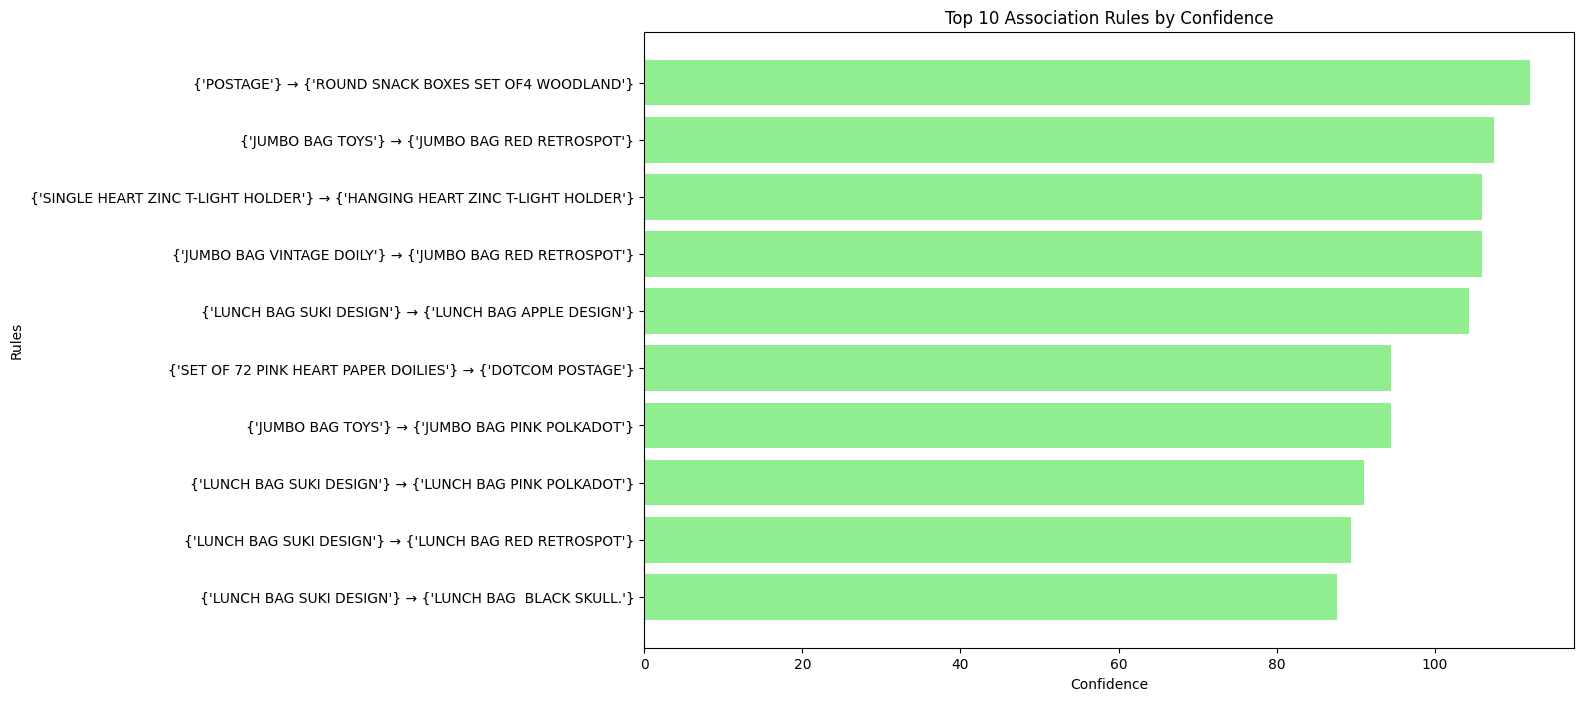

In [41]:
import matplotlib.pyplot as plt

# Sort the rules by confidence and select the top 10
top_rules = association_rules.sort_values(by='Confidence', ascending=False).head(10)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_rules['Antecedent'] + ' → ' + top_rules['Consequent'],
         top_rules['Confidence'], color='lightgreen')
plt.title('Top 10 Association Rules by Confidence')
plt.xlabel('Confidence')
plt.ylabel('Rules')
plt.gca().invert_yaxis()  # Reverse the order of the bars
plt.show()


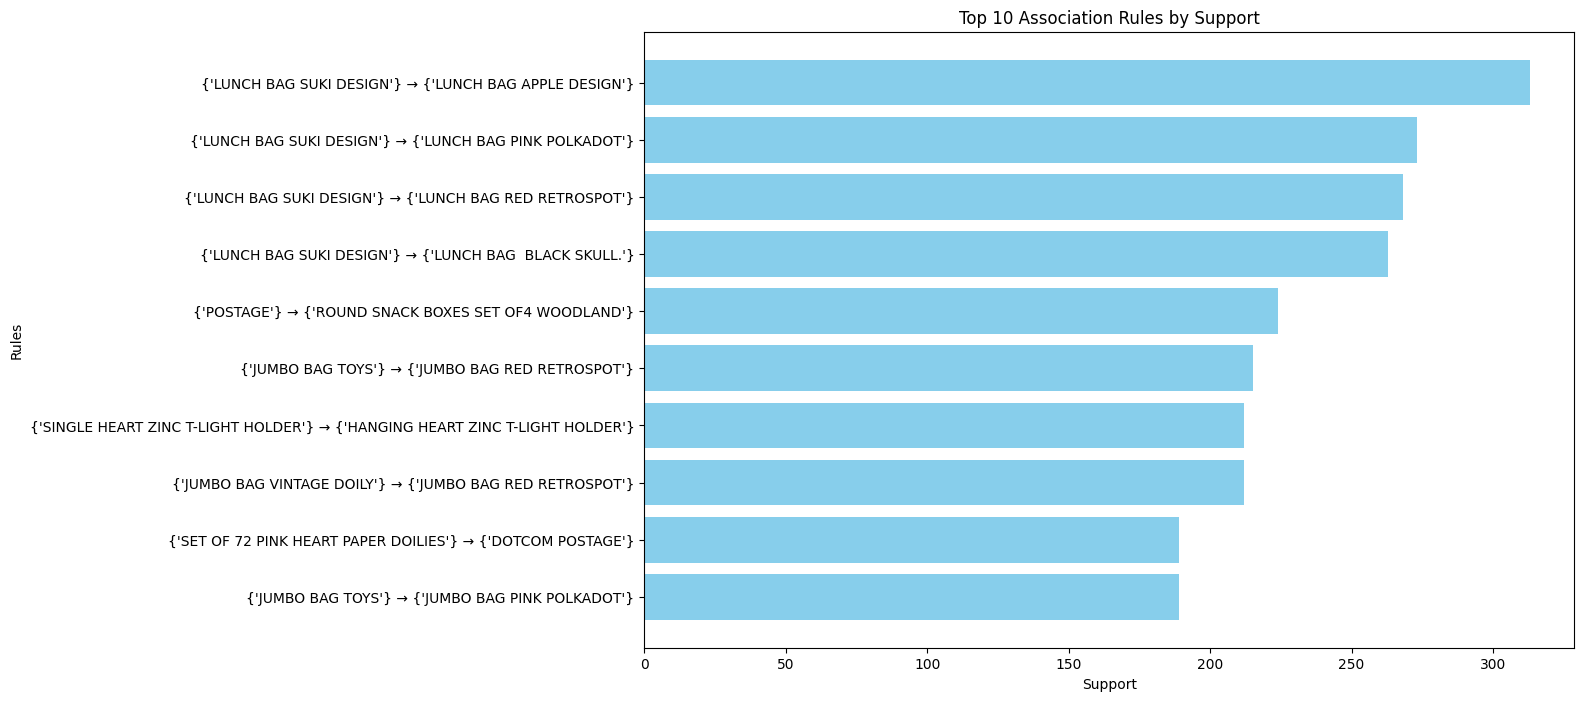

In [42]:
# Sort the rules by support and select the top 10
top_rules_support = association_rules.sort_values(by='Support', ascending=False).head(10)

# Create a horizontal bar chart
plt.figure(figsize=(12, 8))
plt.barh(top_rules_support['Antecedent'] + ' → ' + top_rules_support['Consequent'],
         top_rules_support['Support'], color='skyblue')
plt.title('Top 10 Association Rules by Support')
plt.xlabel('Support')
plt.ylabel('Rules')
plt.gca().invert_yaxis()  # Reverse the order of the bars
plt.show()


In [44]:
# Save the top 10 rules by confidence
top_rules.to_csv('top_rules_by_confidence.csv', index=False)

# Save the top 10 rules by support
top_rules_support.to_csv('top_rules_by_support.csv', index=False)

# Save the top 10 rules by lift (if computed)
if 'Lift' in association_rules.columns:
    top_rules_lift.to_csv('top_rules_by_lift.csv', index=False)

print("Top association rules saved to CSV files.")


Top association rules saved to CSV files.


In [46]:
import plotly.express as px

fig = px.scatter(association_rules,
                 x='Support',
                 y='Confidence',
                 size='Lift',
                 color='Lift',
                 hover_data=['Antecedent', 'Consequent'],
                 title='Association Rules Scatter Plot')
fig.show()
